In [1]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from tqdm import tqdm
from functions import ANALYSIS
from architecture import ARCHITECTURE
import architecture

from collections import Counter
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


import tensorflow.keras.backend as K
import keras

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

EXP = 'CD101T10'

obj = ANALYSIS(EXP)
arch_obj = ARCHITECTURE()

In [2]:
P = pd.read_csv('data/ProtSeqForModel.csv')
D = pd.read_csv('data/DrugSeqForModel.csv')
des_drug = np.load('data/DrugDesForModel.npy')
drug_smiles=pd.read_csv('data/drug_smiles.csv')[['drug','smile','seq_char_count']]
DTI_index=pd.read_csv('data/DTI_index.csv')[['target','drug','IC50','unit','activity','target_uniprot']]

In [3]:
# Encode amino acides and smile characters
codes_target = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
char_dict_target = obj.create_dict(codes_target)

codes_drug = [char for char in ''.join(set(''.join(drug_smiles['smile'].values)))]
char_dict_drug = obj.create_dict(codes_drug)

encode_target = obj.integer_encoding(P, char_dict_target) 
encode_drug = obj.integer_encoding(D, char_dict_drug) 

# padding sequences
max_length = 1000
pad_target = pad_sequences(encode_target, maxlen=max_length, padding='post', truncating='post')
pad_drug = pad_sequences(encode_drug, maxlen=max_length, padding='post', truncating='post')

# label/integer encoding output variable: (y)
le = LabelEncoder()
y = le.fit_transform(DTI_index['activity'].tolist())
# One hot encoding of outputs
y = to_categorical(y)

In [4]:
# Define architecture
input_target, att_out_target = arch_obj.protSeq(1000)
input_drug, att_out_drug = arch_obj.drugSeq(1000)
input_drug_des, dense_drug_des_2 = arch_obj.drugDes(111)

concat = Concatenate()([att_out_target,att_out_drug, dense_drug_des_2])

dense_1 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(concat)
#dense_1_dropout = Dropout(0.1)(dense_1)
dense_2 = Dense(256, activation = 'relu',kernel_initializer='glorot_normal')(dense_1)
#dense_3 = Dense(512, activation = 'relu',kernel_initializer='glorot_normal')(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2)

x_output = Dense(3, activation='softmax')(dense_2_dropout)

# Bulid and compile model
model1 = Model(inputs=[input_target, input_drug, input_drug_des], outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#model1.summary()

In [5]:
# Split indics into train/test
from sklearn.model_selection import train_test_split
indices = list(range(len(DTI_index)))
train_target, test_target, train_drug, test_drug, train_des, test_des, y_train, y_test = train_test_split(pad_target, pad_drug, des_drug, y, test_size=0.2, random_state=20)

print(train_target.shape, test_target.shape, train_drug.shape, test_drug.shape)

(49299, 1000) (12325, 1000) (49299, 1000) (12325, 1000)


In [6]:
# Early Stopping & checkpoint
es = EarlyStopping(monitor='val_loss', patience=40, verbose=1)
filepath='checkpoints/'+EXP+'/'+EXP+'_cp.hdf5'
model_checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model1.fit(
    [train_target, train_drug, train_des], y_train,
    epochs=500, batch_size=256,
    validation_split=0.2,
    callbacks=[es, model_checkpoint]
    )

step - loss: 0.6562 - accuracy: 0.7302 - val_loss: 0.7188 - val_accuracy: 0.7024
Epoch 195/500
155/155 [==============================] - ETA: 0s - loss: 0.6481 - accuracy: 0.7347
Epoch 00195: val_loss did not improve from 0.71879
155/155 [==============================] - 31s 198ms/step - loss: 0.6481 - accuracy: 0.7347 - val_loss: 0.7349 - val_accuracy: 0.6948
Epoch 196/500
155/155 [==============================] - ETA: 0s - loss: 0.6445 - accuracy: 0.7359
Epoch 00196: val_loss improved from 0.71879 to 0.71726, saving model to checkpoints/CD101T10/CD101T10_cp.hdf5
155/155 [==============================] - 31s 199ms/step - loss: 0.6445 - accuracy: 0.7359 - val_loss: 0.7173 - val_accuracy: 0.7023
Epoch 197/500
155/155 [==============================] - ETA: 0s - loss: 0.6450 - accuracy: 0.7370
Epoch 00197: val_loss did not improve from 0.71726
155/155 [==============================] - 31s 198ms/step - loss: 0.6450 - accuracy: 0.7370 - val_loss: 0.7253 - val_accuracy: 0.6976
Epoch 19

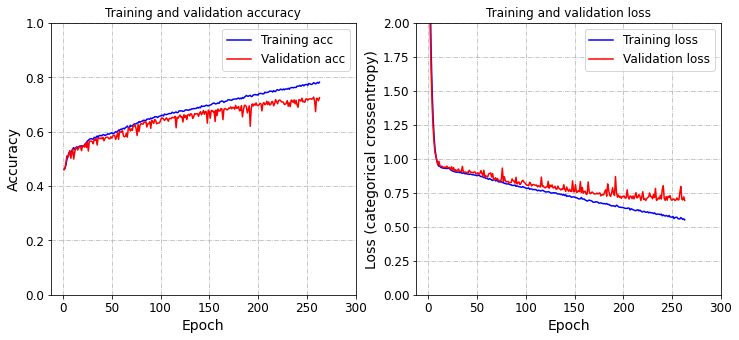

In [7]:
obj.plotTrainingPerf(history, save=False)

In [8]:
# Load saved model
saved_model = load_model('checkpoints/'+EXP+'/'+EXP+'_cp.hdf5', custom_objects={'attention': architecture.attention()})

In [9]:
# Calculate ROC and PR characteristics
roc_auc, fpr, tpr = obj.roc(saved_model, y_test, a = test_target, b = test_drug, c = test_des)
precision, recall, average_precision = obj.aupr(saved_model, y_test, a = test_target, b = test_drug, c = test_des)

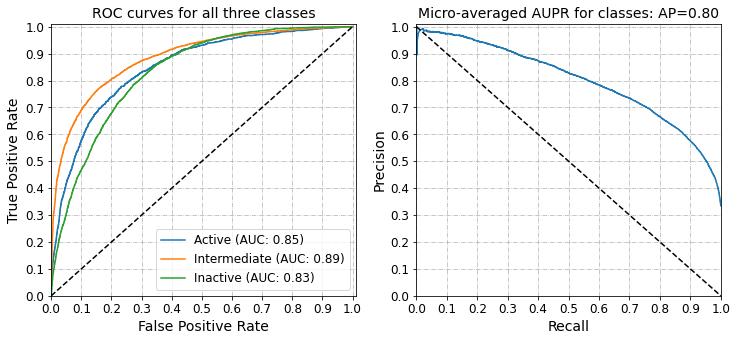

In [10]:
# Plot ROC/PR curve
obj.plotROC_PR(fpr, tpr, roc_auc, precision, recall, average_precision, save=True)

In [25]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = saved_model.evaluate([test_target, test_drug, test_des], y_test, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
49/49 [==============================] - 4s 80ms/step - loss: 0.6933 - accuracy: 0.7196
test loss, test acc: [0.6933453679084778, 0.7195942997932434]


In [31]:
# EXTERNAL VALIDATION
davis_metz_DTI = pd.read_csv('val_data/davis_metz_DTI.csv')
davis_metz_targets = os.listdir('val_data/fasta_davis_metz')  # List all target fasta files
davis_metz_drug_smiles = pd.read_csv('val_data/davis_metz_smiles.csv')
davis_metz_drug_des = pd.read_csv('val_data/fset_drugs_davis_metz.csv')
davis_metz_drug_des = davis_metz_drug_des.loc[:, davis_metz_drug_des.columns != 'Unnamed: 0']

# Fetch fasta sequences form files and create target index dataframe
def fetchFasta(targets):
    target_seq = pd.DataFrame(columns=['target','seq'])
    for fasta in tqdm(targets):
        f = open('val_data/fasta_davis_metz/'+fasta,'r')
        lines = "".join(line.strip() for line in f.readlines()[1:])
        dict = {'target':fasta.split('.')[0], 'seq':lines}
    
        target_seq = target_seq.append(dict, True)
        f.close()
    return target_seq

davis_metz_target_seq = fetchFasta(davis_metz_targets)

100%|██████████| 154/154 [00:00<00:00, 697.50it/s]


In [32]:
eval_P = pd.DataFrame()
for target in davis_metz_DTI['protein_id']:
    dic = davis_metz_target_seq[davis_metz_target_seq['target']==target]
    eval_P = eval_P.append(dic)

eval_T = pd.DataFrame()
for drug in davis_metz_DTI['compound_id']:
    dic = davis_metz_drug_smiles[davis_metz_drug_smiles['drug']==drug][['drug', 'seq']]
    eval_T = eval_T.append(dic)

eval_D = pd.DataFrame()
for drug in davis_metz_DTI['compound_id']:
    des = davis_metz_drug_des[davis_metz_drug_des['Drug']==drug]
    dic = des.loc[:,des.columns!='Drug']
    eval_D = eval_D.append(dic)

# label/integer encoding output variable: (y)
davis_metz_le = LabelEncoder()
davis_metz_y = davis_metz_le.fit_transform(davis_metz_DTI['activity'].tolist())
# One hot encoding of outputs
davis_metz_y = to_categorical(davis_metz_y)

In [33]:
davis_metz_codes_drug = [char for char in ''.join(set(''.join(davis_metz_drug_smiles['seq'].values)))]
davis_metz_char_dict_drug = obj.create_dict(davis_metz_codes_drug)

davis_metz_encode_target = obj.integer_encoding(eval_P, char_dict_target) 
davis_metz_encode_drug = obj.integer_encoding(eval_T, davis_metz_char_dict_drug) 

# padding sequences
max_length = 1000
davis_metz_pad_target = pad_sequences(davis_metz_encode_target, maxlen=max_length, padding='post', truncating='post')
davis_metz_pad_drug = pad_sequences(davis_metz_encode_drug, maxlen=max_length, padding='post', truncating='post')

davis_metz_pad_target.shape, davis_metz_pad_drug.shape, eval_D.shape, davis_metz_y.shape

((2575, 1000), (2575, 1000), (2575, 111), (2575, 3))

In [36]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = saved_model.evaluate([davis_metz_pad_target, davis_metz_pad_drug, eval_D.values], davis_metz_y, batch_size=256)
print("test loss, test acc:", results)

Evaluate on test data
11/11 [==============================] - 3s 262ms/step - loss: 14.8765 - accuracy: 0.2540
test loss, test acc: [14.876453399658203, 0.2539805769920349]


In [37]:
# Calculate ROC and PR characteristics
roc_auc, fpr, tpr = obj.roc(saved_model, davis_metz_y, a = davis_metz_pad_target, b = davis_metz_pad_drug, c = eval_D.values)
precision, recall, average_precision = obj.aupr(saved_model, davis_metz_y, a = davis_metz_pad_target, b = davis_metz_pad_drug, c = eval_D.values)

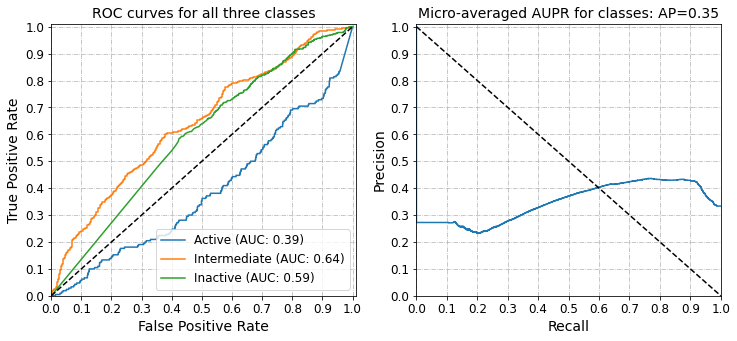

In [38]:
# Plot ROC/PR curve
obj.plotROC_PR(fpr, tpr, roc_auc, precision, recall, average_precision, save=False)